# Building a custom provider

Worldex was developed to be easily extended to different data providers. Building a custom one can be broken down into a few steps.

1. Fetching and setting the metadata
2. Accessing the data
3. Indexing the data

## Fetching and setting the metadata

The first step is to create a dataset object from existing metadata. This data could come from a html page, a rest api, or even an existing python object. This would then create a new instance of the class with everything setup. 

The code below is an example on how a provider where you need to fetch html and parse it would look like. There are some custom provider custom that could be set here.

In [ ]:
# from html
from bs4 import BeautifulSoup
from datetime import datetime
import requests
from worldex.datasets.dataset import BaseDataset

class CustomProvider(BaseDataset):
    ...
    # Add provider constants here
    source_org: str = "Custom Org"
    projection: str ="EPSG:4326", 
    accessibility: str ="public/open",
    @classmethod
    def from_url(cls, url):
        response = requests.get(url)
        soup = BeautifulSoup(response.text, "html.parser")
        data = {}
        # from soup search different properties 
        # and would then same them to the data dict
        return cls(
            name=data["title"],
            last_fetched=datetime.now().isoformat(),
            files=data["files"],
            description=data["description"],
            properties={},
            keywords=[],
            date_start=data['date_start'],
            date_end=data['date_end'],
            url=url,
        )

## Accessing the data

Depending on the data provider and the data itself, there might be different needed steps to access the data. You might need an API Key to access the files, the files might be zipped into a single file than you would need to unzipped, there might be multiple files some of which can't be index. The general workflow we suggest is to have a method that downloads the files locally, unzips them if needed.

In [ ]:
import os
from pathlib import Path

from pyunpack import Archive
from worldex.datasets.dataset import BaseDataset
from worldex.utils.filemanager import download_file

class CustomProvider(BaseDataset):
    ...
    def download(self):
        for file in self.files:
            filename = Path(file).name
            if not os.path.exists(self.dir / filename):
                download_file(file, self.dir / filename)

    def unzip(self):
        for file in filter(
            lambda x: x.endswith(".zip") or x.endswith(".7z"), self.files
        ):
            filename = Path(file).name
            Archive(self.dir / filename).extractall(self.dir)

## Indexing the data

The indexing of data is done via the worldex's `RasterHandler` or `VectorHandlers` or using both if the dataset contains both. This should automatically index the data appropriately. This is also the step where we set the bounding box (`bbox`) field and other possible file specific fields.


### Single file indexing
Single file indexing follows a few steps
1. you just need to donwload the file
2. unzip if needed, get the path to the file
3. use the vector or raster handler to index the data
4. save the bbox and other parameters if needed 
5. then write the indexes as dataframe using `self.write(df)`

This would then write the dataframe and metadata to the dir

In [ ]:
import pandas as pd
from shapely.geometry import box
from shapely import wkt
from worldex.handlers.raster_handlers import RasterHandler
class CustomProvider(BaseDataset):
    def index(self):
        self.download()
        path_to_file = self.dir / "..."
        handler = RasterHandler.from_file(path_to_file)
        # window parameter is a raster handler specific parameter
        # it slices the indexing into 10 by 10 windows to minimize memory usage
        h3indices = handler.h3index(window=(10, 10))
        self.bbox = wkt.dumps(box(*handler.bbox))
        df = pd.DataFrame({"h3_index": h3indices})
        self.write(df)
        return df

### Multiple files
Multi file indexing follows the similar steps but you have to keep track of the indices , deduplicate them, and combine the bbox using each file's bbox.

In [ ]:
from shapely.geometry import box
from shapely.ops import unary_union
from shapely import wkt

import pandas as pd

from worldex.handlers.vector_handlers import VectorHandler
class CustomProvider(BaseDataset):
    ...
    def index(self):
        self.download()
        self.unzip()
        boxes = []
        indices = []
        # Find file
        shp_files = list(self.dir.glob("**/*.shp")) 
        for file in shp_files:
            handler = VectorHandler.from_file(file)
            h3indices = handler.h3index()
            boxes.append(box(*handler.bbox))
            indices.append(pd.DataFrame({"h3_index": h3indices}))

        # combine bboxess
        self.bbox = wkt.dumps(box(*unary_union(boxes).bounds))
        # combine indices and deduplicate
        df = pd.concat(indices).drop_duplicates()

        self.write(df)
        return df

## Putting it all together

Here is an actual example of using Geofrabik. A data provides that host OSM data per country.

In [18]:
import os
import re
from datetime import datetime
from pathlib import Path
from urllib.parse import urljoin

import pandas as pd
import requests
from bs4 import BeautifulSoup
from pyunpack import Archive
from shapely import wkt
from shapely.geometry import box
from shapely.ops import unary_union

from worldex.datasets.dataset import BaseDataset
from worldex.handlers.vector_handlers import VectorHandler
from worldex.utils.filemanager import download_file


class GeofrabikDataset(BaseDataset):
    source_org: str = "Geofrabik"
    projection: str = "EPSG:4326", 
    accessibility: str = "public/open",
    @classmethod
    def from_url(cls, url):
        response = requests.get(url)
        soup = BeautifulSoup(response.text, "html.parser")
        country = soup.find("h2").text
        title = f"OSM data for {country}"
        description = f"OSM data for {country} processed and provided by Geofabrik"
        relative_path = soup.find("a", {"href": re.compile(".shp.")})["href"]
        files = [urljoin(url, relative_path)]
        return cls(
            name=title,
            last_fetched=datetime.now().isoformat(),
            files=files,
            description=description,
            data_format="Shapefile",
            properties={},
            keywords=[],
            url=url,
            # Constant values specific to the provider can also be set
            projection="EPSG:4326",
            accessibility="public/open",
        )

    def download(self):
        for file in self.files:
            filename = Path(file).name
            if not os.path.exists(self.dir / filename):
                download_file(file, self.dir / filename)

    def unzip(self):
        for file in filter(lambda x: x.endswith(".zip"), self.files):
            filename = Path(file).name
            Archive(self.dir / filename).extractall(self.dir)

    def index(self):
        self.download()
        self.unzip()
        boxes = []
        indices = []
        # Find files. For this example, we will only use 1 file
        shp_files = list(self.dir.glob("**/*pois_a_free_1.shp"))
        for file in shp_files:
            handler = VectorHandler.from_file(file)
            h3indices = handler.h3index()
            boxes.append(box(*handler.bbox))
            indices.append(pd.DataFrame({"h3_index": h3indices}))

        # combine bboxes
        self.bbox = wkt.dumps(box(*unary_union(boxes).bounds))
        # combine indices and deduplicate
        df = pd.concat(indices).drop_duplicates()

        self.write(df)
        return df


In [19]:
thailand = GeofrabikDataset.from_url("https://download.geofabrik.de/asia/thailand.html")
thailand.set_dir("test_dir")
thailand.index()

,h3_index
0,8864a4b14dfffff
1,8864a4ba07fffff
2,8864a4ba2bfffff
3,8864a4b121fffff
4,88658e0c81fffff
...,...
2242,8864a4b129fffff
2243,8864a4b627fffff
2244,886588683bfffff
2245,8864a2429dfffff


In [20]:
import json
with open(thailand.dir/"metadata.json") as f:
    metadata = json.load(f)

metadata

{'id': '3b342363-5f37-4921-9ba4-1bd299fb1999',
 'name': 'OSM data for Thailand',
 'source_org': 'Geofrabik',
 'last_fetched': '2024-06-18T21:10:25.507120',
 'files': ['https://download.geofabrik.de/asia/thailand-latest-free.shp.zip'],
 'description': 'OSM data for Thailand processed and provided by Geofabrik',
 'data_format': 'Shapefile',
 'projection': 'EPSG:4326',
 'properties': {},
 'bbox': 'POLYGON ((105.6030401000000012 5.7456041000000004, 105.6030401000000012 20.4476778000000010, 97.5483676000000060 20.4476778000000010, 97.5483676000000060 5.7456041000000004, 105.6030401000000012 5.7456041000000004))',
 'keywords': [],
 'date_start': None,
 'date_end': None,
 'accessibility': 'public/open',
 'url': 'https://download.geofabrik.de/asia/thailand.html'}

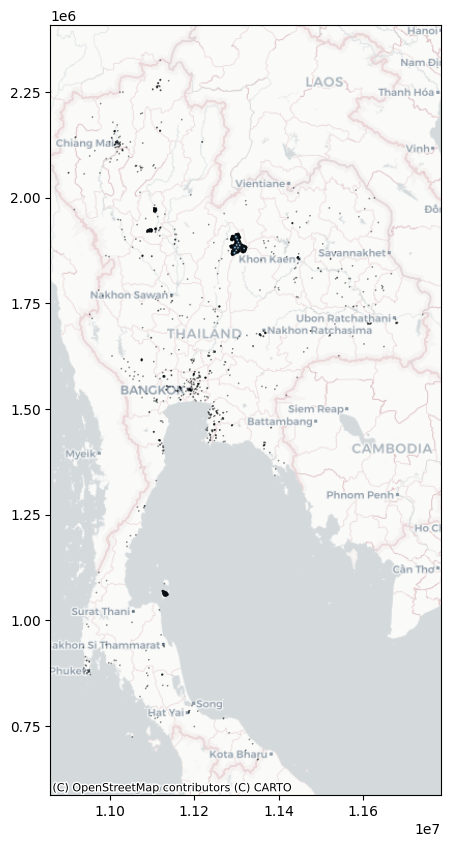

In [21]:
from worldex.visualizations import viz
viz(thailand.dir / "h3-compact.parquet")